## Example 2: Four-Qubit Quantum Fourier Transform (QFT)

### Purpose

This example assumes familiarity with the basics of TinyQsim from example 1. It shows how we can build a quantum circuit for a 4-qubit Quantum Fourier Transform (QFT). It then creates an inverse QFT to show how we can make the inverse of a quantum circuit.

Example 3 goes on to extend this 4-qubit QFT to a more general N-qubit QFT.

We will start by importing TinyQsim and the Python libraries that we will need:

In [1]:
PI = '\u03C0'  # PI unicode
from math import pi

import numpy as np

from tinyqsim.qcircuit import QCircuit

### The Quantum Fourier Transform

The Quantum Fourier Transform (QFT) is in important algorithm in quantum computing. It is used for estimating phase and periodicities in algorithms such as Shor's well-known integer factorization algorithm.

The QFT has the same effect as applying the normal inverse Discrete Fourier Transform (DFT) to the quantum state vector. It is equivalent to the *inverse* DFT, rather than forward DFT, simply because a different sign convention is normally used. However, for a quantum computer, we have to find a way to implement the transform using only quantum gates.

The inverse DFT, with $\frac{1}{\sqrt{N}}$ normalization, can be defined as:

$$
\qquad X_n = \frac{1}{\sqrt{N}} \sum_{m=0}^{N-1} x_m\omega_N^{mn},\quad n=0,1,2,\dots,N-1
$$

where $\omega_N = e^\frac{2\pi i}{N}$

The result is in bit-reversed order, so we need to finally apply a bit-reversal operation.

The DFT can be expressed as a unitary matrix as follows, where the $\omega^0$ terms have been written as $1$.

$$
\qquad
U_N=\frac{1}{\sqrt{N}}\begin{bmatrix}1&1&1&\dots&1\\
1&\omega&\omega^2&\dots&\omega^{N-1}\\
1&\omega^2&\omega^4&\dots&\omega^{2(N-1)}\\
\vdots&\vdots&\vdots&\dots&\vdots\\
1&\omega^{N-1}&\omega^{2(N-1)}&\dots&\omega^{(N-1)(N-1)}\\
\end{bmatrix}
$$

The QFT is equivalent to the application of this unitary matrix to the quantum state. The columns of the matrix are the DFTs of the N orthogonal quantum basis vectors $[1,0,0,\dots], [0,1,0,\dots],[0,0,1,\dots], $etc. Because of linearity, we can apply it to a general quantum state that is a superposition of the basis states.

However, we still need to build the unitary out of standard quantum gates to realise it on a quantum computer. The QFT algorithm is an ingeneous way to decompose the matrix into the sequential application of Hadamard (H) gates and Controlled-phase (CP) gates.

The time complexity of the basic DFT algorithm is $\mathcal{O}(n^2)$. However, it is normally implemented by the Fast Fourier Transform algorithm which is $\mathcal{O}(n\log{}n)$. The normal QFT algorithm does even better at $\mathcal{O}(\log^2{}n)$, which is exponentially faster than even the FFT. However, this assumes that we can efficiently implement a CP gate where the 2 qubits are non-adjacent. In practice, a quantum computer can normally only perform such operations on physically-adjacent qubits and so there may be some overhead in iperforming 'swap' operations to move the qubits around.

The details of how the QFT algorithm works are beyond the scope of this short introduction. A key part is using phase gates to rotate the phase of qubits to perform the $\omega_n$ phase shifts.

### 4-Qubit QFT

TinyQsim doesn't support sub-circuits but we can define a function to build the QFT circuit. We can then use it more than once in a notebook, for example to try different initial conditions.

We can build the 4-qubit QFT as follows:

In [2]:
def qft4(qc):
    """4-qubit QFT."""
    qc.h(0)
    qc.cp(pi / 2, f'{PI}/2', 0, 1)
    qc.cp(pi / 4, f'{PI}/4', 0, 2)
    qc.cp(pi / 8, f'{PI}/8', 0, 3)
    qc.h(1)
    qc.cp(pi / 2, f'{PI}/2', 1, 2)
    qc.cp(pi / 4, f'{PI}/4', 1, 3)
    qc.h(2)
    qc.cp(pi / 2, f'{PI}/2', 2, 3)
    qc.h(3)
    qc.swap(0, 3)  # Reverse order of qubits
    qc.swap(1, 2)

The `swap` gates are used to reverse the order of qubits in the result of the QFT. This is like the bit-reversal that is performed in a normal Discrete Fourier Transform (DFT).

We will start by creating a 4-qubit circuit and initializing the state to $\ket{0010}$, as the state we wish to transform:

In [3]:
qc = QCircuit(4)
qc.x(2)  # Initial state
qc.barrier()
print(qc.format_probabilities())

|0010⟩  1


We can run the QFT as follows:

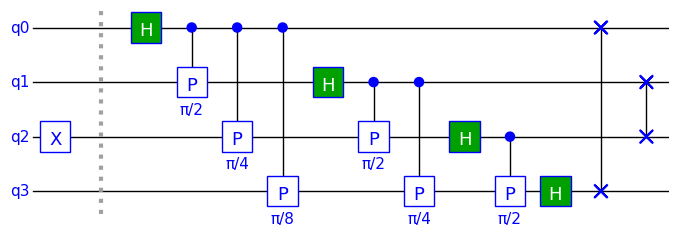

In [4]:
qft4(qc)
qc.draw()

The barrier symbol is used for clarity to separate initialization of the state from the actual QFT.

In [5]:
print(qc.format_probabilities(edge=3))

|0000⟩  0.0625
|0001⟩  0.0625
|0010⟩  0.0625
...
|1101⟩  0.0625
|1110⟩  0.0625
|1111⟩  0.0625


The probability of every outcome is 1/16, so all 16 measurement outcomes are equally likely.

However, if we examine the phase angle (in degrees), we can see that the phase is varying periodically:

In [6]:
sv = qc.state_vector
print(np.atan2(sv.imag, sv.real) * 180 / np.pi)

[   0.   45.   90.  135.  180. -135.  -90.  -45.    0.   45.   90.  135.
  180. -135.  -90.  -45.]


### Comparing DFT and QFT

It was mentioned above that the QFT gives the same result as the inverse DFT applied to the quantum state vector. The following code creates a random state and generates both the QFT and FFT (DFT), then compares them.

In [7]:
qc = QCircuit(4, init='random')
qc.x(2)
state = np.array(qc.state_vector)  # Save copy of state

# Using QFT
qft4(qc)
qft_result = qc.state_vector

# Using DFT
dft_result = np.fft.ifft(state, norm='ortho')  # Numpy inverse FFT

# Compare the results
print(np.isclose(qft_result, dft_result).all())

True


This should print 'True', indicating that the two results are the same.

### Inverse QFT

Quantum circuits (excluding collapse measurements) are reversible as they are unitary. To run a circuit in reverse, we reverse the order of the sequence of gates and replace each gate by its conjugate transpose:

$$
\qquad (U_1 U_2\dots U_{n-1})^\dagger = U^\dagger_{n-1}\dots U^\dagger_2 U^\dagger_1
$$

In the QFT circuit above, the Hadamard and swap gates are Hermitian (i.e. equal to their own conjugates transposes). The conjugate transpose of the phase gate is given by:

$$
\qquad P^\dagger(\phi) = P(-\phi)
$$

Consequently, the inverse 4-qubit QFT can be constructed as follows:

In [8]:
def iqft4(qc):
    """4-qubit inverse QFT."""
    qc.swap(1, 2)
    qc.swap(0, 3)  # Reverse order of qubits
    qc.h(3)
    qc.cp(-pi / 2, f'-{PI}/2', 2, 3)
    qc.h(2)
    qc.cp(-pi / 4, f'-{PI}/4', 1, 3)
    qc.cp(-pi / 2, f'-{PI}/2', 1, 2)
    qc.h(1)
    qc.cp(-pi / 8, f'-{PI}/8', 0, 3)
    qc.cp(-pi / 4, f'-{PI}/4', 0, 2)
    qc.cp(-pi / 2, f'-{PI}/2', 0, 1)
    qc.h(0)

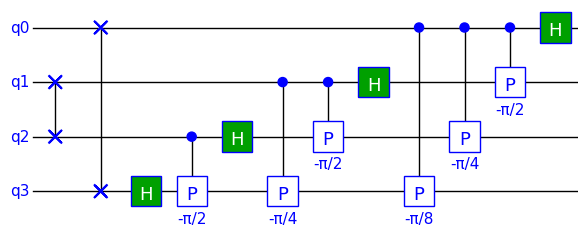

In [9]:
qc = QCircuit(4)
iqft4(qc)
qc.draw()

### Testing the Inverse QFT

We can test the inverse QFT by taking the forward QFT of a random state, followed by the inverse QFT and checking that we get the state that we started with:

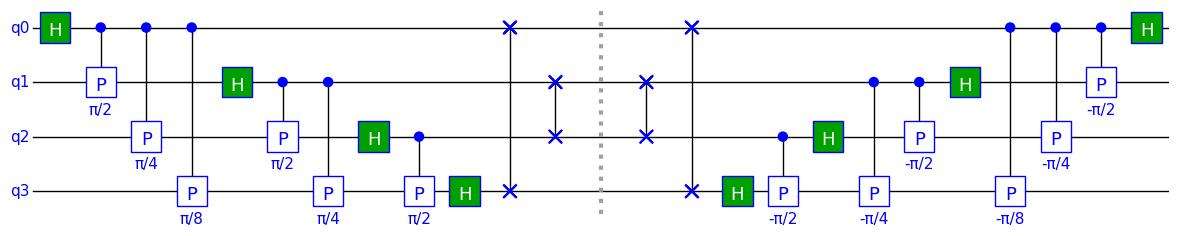

Result: True


In [10]:
qc = QCircuit(4, init='random')
initial_state = qc.state_vector
qft4(qc)
qc.barrier()
iqft4(qc)
qc.draw()
print('Result:', np.allclose(qc.state_vector, initial_state))

This should print 'True', indicating that the inverse QFT has completely undone the effect of the forward QFT.

Observe how each step of the inverse QFT undoes the corresponding step of the forward QFT, until we are left with the original random state.